# Linear regression

### Import libraries and set random state

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

random_state = 44

### Import and scale data

In [243]:
df = pd.read_csv("../features.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name', 'file_name'])
y = df['malign']

In [244]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

### Pick best percentiles and C for filter methods

In [246]:
from sklearn.feature_selection import GenericUnivariateSelect, \
    VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

percentiles = [30, 60, 67, 90, 93, 95, 97, 99]
results = {"mutual_info_classif": [], "chi2": [], "f_classif": []}
GUS_pipe_best_dict = {}
score_funcs = [mutual_info_classif, chi2, f_classif]
best_f1 = 0
GUS_pipe_best = None

for fun, name in zip(score_funcs, list(results.keys())):
    best_f1 = 0
    best_c = 0
    percentile_best = None
    for c in [0.3, 0.9, 1, 3, 6, 9]:
        for percentile in percentiles:
            GUS_pipe = Pipeline([("VarianceThreshold", VarianceThreshold()), 
                                ("FeatureSelection", GenericUnivariateSelect(score_func=fun, param=percentile)),
                                ("LogisticRegression", LogisticRegression(C=c, random_state=random_state, max_iter=10**4))])
            GUS_pipe.fit(X_train, y_train)
            f1 = f1_score(y_val, GUS_pipe.predict(X_val))
            results[name].append(f1)
            if f1 > best_f1:
                best_f1 = f1
                GUS_pipe_best = GUS_pipe
                percentile_best = percentile
                best_c = c
    GUS_pipe_best_dict[name] = GUS_pipe_best
    print(f'{name}, best pericentile: {percentile_best}, best f1: {best_f1}, best C: {best_c}')

mutual_info_classif, best pericentile: 93, best f1: 0.8059701492537312, best C: 3
chi2, best pericentile: 97, best f1: 0.8181818181818182, best C: 6
f_classif, best pericentile: 95, best f1: 0.8125000000000001, best C: 3


### Create 4 models - 3 with filter selection, 1 with wrapper selection

In [247]:
from sklearn.feature_selection import GenericUnivariateSelect, RFECV, \
    VarianceThreshold, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

GUS_MI = GUS_pipe_best_dict["mutual_info_classif"]
GUS_CHI = GUS_pipe_best_dict["chi2"]
GUS_FC = GUS_pipe_best_dict["f_classif"]

f1_scorer = make_scorer(f1_score)
clf_RFECV = RFECV(estimator=LogisticRegression(random_state=random_state, max_iter=1000),
                  scoring=f1_scorer,
                  step=0.05, n_jobs=-1)
# SFS = Pipeline([("FeatureSelection", SequentialFeatureSelector(
#                                 estimator=LogisticRegression(random_state=random_state, max_iter=100), 
#                                 scoring=f1_scorer, 
#                                 n_jobs=-1)),
#                 ("LogisticRegression", LogisticRegression(random_state=random_state, max_iter=10**4))])

clfs = [GUS_MI, GUS_CHI, GUS_FC, clf_RFECV]
clfs_names = ["GUS Mutual Info", "GUS chi-squared", "GUS ANOVA F-value", "RFECV"]

for clf, name in zip(clfs, clfs_names):
    print("Fitting: ", name)
    clf = clf.fit(X_train, y_train)

Fitting:  GUS Mutual Info
Fitting:  GUS chi-squared
Fitting:  GUS ANOVA F-value
Fitting:  RFECV


### Evaluate performance

In [248]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.869202,0.735460,0.848485,0.649007
1,GUS chi-squared,0.884045,0.771481,0.861224,0.698675
2,GUS ANOVA F-value,0.872913,0.741996,0.860262,0.652318
3,RFECV,0.841373,0.657315,0.832487,0.543046


In [249]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.881481,0.757576,0.833333,0.694444
1,GUS chi-squared,0.911111,0.818182,0.900000,0.750000
2,GUS ANOVA F-value,0.911111,0.812500,0.928571,0.722222
3,RFECV,0.888889,0.769231,0.862069,0.694444


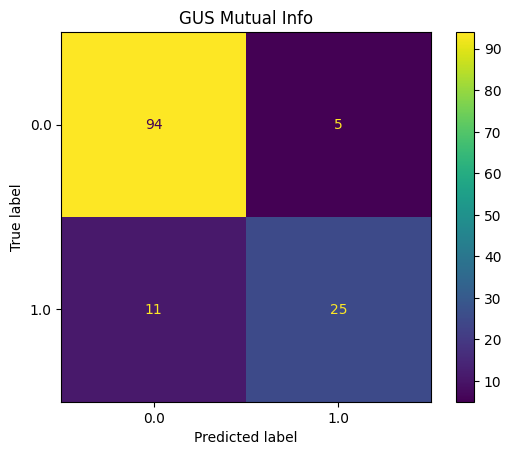

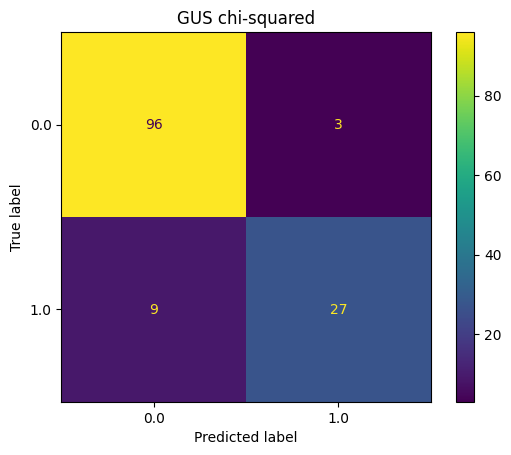

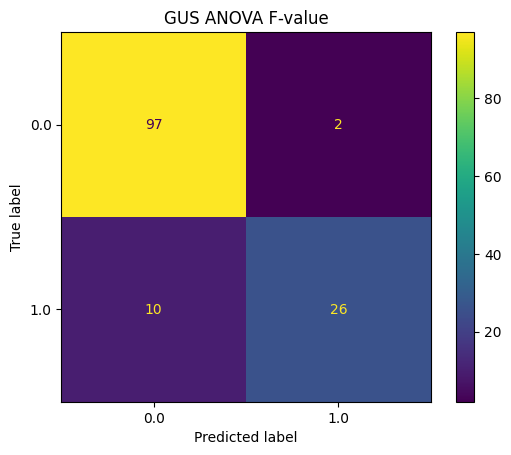

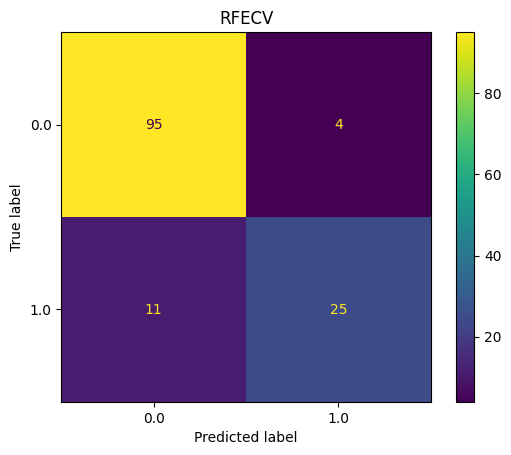

In [250]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

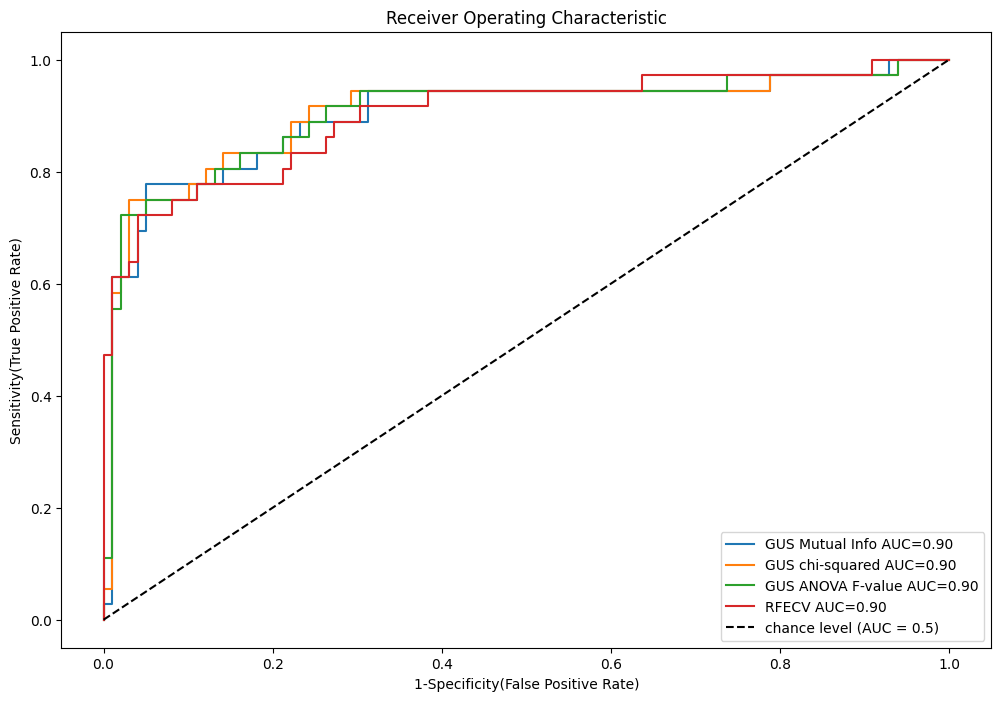

In [251]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_val)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    thresholds = np.append(thresholds, 0.5)
    clfs_thresholds[name] = thresholds
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [252]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = None
    thresholds = list(clfs_thresholds[name])
    thresholds.append(0.5)
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th

In [253]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.896296,0.794118,0.843750,0.750000,0.454647
1,GUS chi-squared,0.911111,0.818182,0.900000,0.750000,0.500000
2,GUS ANOVA F-value,0.911111,0.812500,0.928571,0.722222,0.500000
3,RFECV,0.888889,0.769231,0.862069,0.694444,0.486714


In [254]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.851852,0.655172,0.904762,0.513514
1,GUS chi-squared,0.866667,0.709677,0.880000,0.594595
2,GUS ANOVA F-value,0.866667,0.700000,0.913043,0.567568
3,RFECV,0.851852,0.666667,0.869565,0.540541


In [255]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.866667,0.700000,0.913043,0.567568,0.454647
1,GUS chi-squared,0.866667,0.709677,0.880000,0.594595,0.500000
2,GUS ANOVA F-value,0.866667,0.700000,0.913043,0.567568,0.500000
3,RFECV,0.844444,0.655738,0.833333,0.540541,0.486714


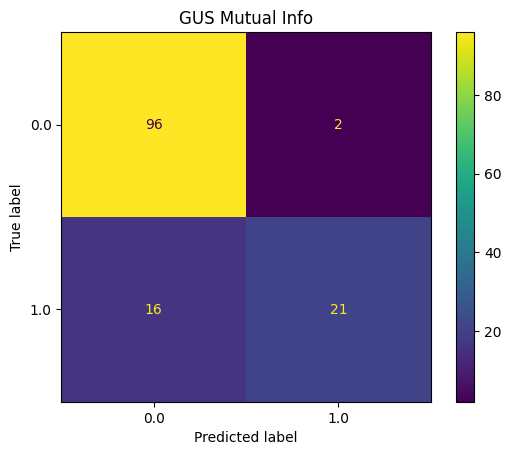

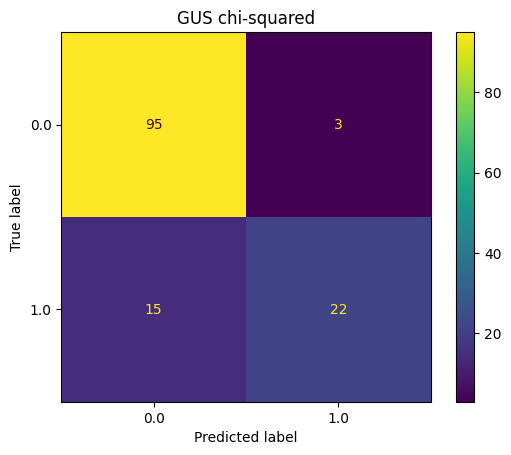

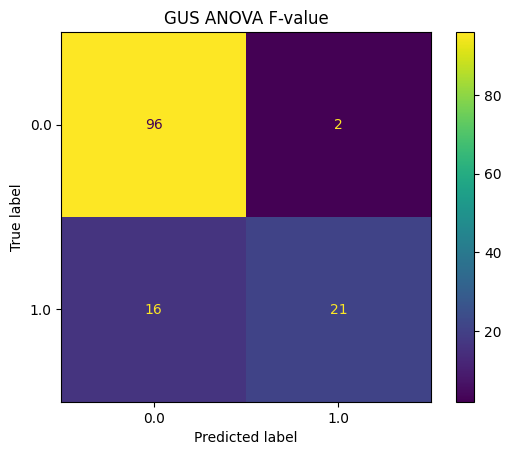

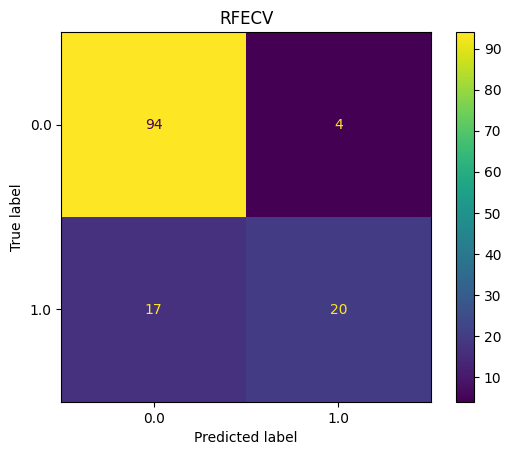

In [256]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

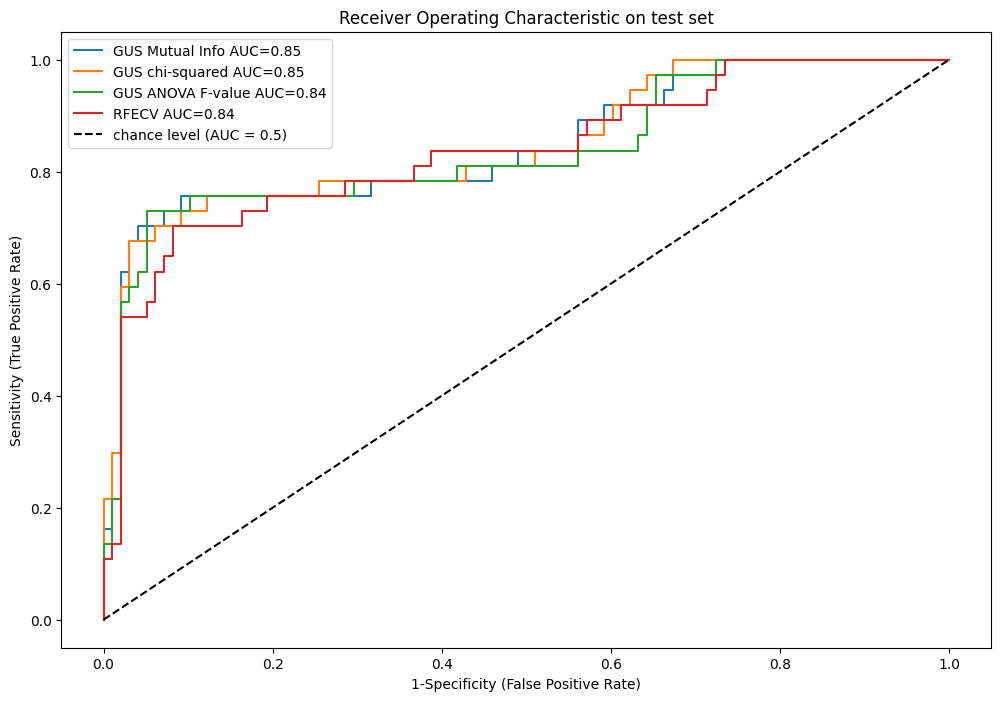

In [257]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
plt.figure(figsize=(12,8))
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    clfs_thresholds[name] = thresholds

    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic on test set')
plt.legend()
plt.show()

### Review feature selection

In [258]:

from sklearn.feature_selection import SelectFromModel

def count_classes(selected, feature_classes, original=None):
    results = []
    sum = 0
    for feature_class in feature_classes:
        counter = 0
        for elem in selected:
            if feature_class == 'square':
                if feature_class in elem and 'squareroot' not in elem:
                    counter += 1
            elif feature_class in elem:
                counter += 1
        sum += counter
        results.append([feature_class, counter])
    results.append(["sum", sum])
    results = pd.DataFrame(results, columns=["Feature class name", "Count"])

    if original is not None:
        original_count = count_classes(original, feature_classes)["Count"]
        results["Percent kept"] = results["Count"] / original_count
        results["Original Count"] = original_count

    results.head(len(feature_classes))
    return results

def get_selected_from_support(support, columns):
    df_selected = pd.DataFrame({'Column': columns,
                             'Kept': support})
    selected = df_selected[df_selected['Kept'] == True]['Column']
    return selected

feature_classes = ['lbp-2D', 'gradient', 'exponential', 'logarithm', 'squareroot', 'square', 'wavelet-L', 'wavelet-H', 'original']


X = df.drop(columns=['malign', 'patient_name', 'file_name'])

selected = get_selected_from_support(clf_RFECV.support_, X.columns)
count_classes(selected, feature_classes, X.columns)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,25,0.274725,91
1,gradient,44,0.483516,91
2,exponential,39,0.428571,91
3,logarithm,43,0.472527,91
4,squareroot,42,0.461538,91
5,square,51,0.560440,91
6,wavelet-L,61,0.670330,91
7,wavelet-H,51,0.560440,91
8,original,62,0.620000,100
9,sum,418,0.504831,828


In [259]:
selected_after_var = get_selected_from_support(GUS_CHI["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_CHI["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,46,0.901961,51
1,gradient,90,0.989011,91
2,exponential,88,0.967033,91
3,logarithm,89,0.978022,91
4,squareroot,86,0.945055,91
5,square,89,0.978022,91
6,wavelet-L,91,1.000000,91
7,wavelet-H,85,0.934066,91
8,original,100,1.000000,100
9,sum,764,0.969543,788


In [260]:
selected_after_var = get_selected_from_support(GUS_FC["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_FC["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,37,0.725490,51
1,gradient,88,0.967033,91
2,exponential,89,0.978022,91
3,logarithm,88,0.967033,91
4,squareroot,83,0.912088,91
5,square,85,0.934066,91
6,wavelet-L,91,1.000000,91
7,wavelet-H,88,0.967033,91
8,original,99,0.990000,100
9,sum,748,0.949239,788


In [261]:
selected_after_var = get_selected_from_support(GUS_MI["VarianceThreshold"].get_support(), X.columns)
selected = get_selected_from_support(GUS_MI["FeatureSelection"].get_support(), selected_after_var)
count_classes(selected, feature_classes, selected_after_var)

,Feature class name,Count,Percent kept,Original Count
0,lbp-2D,38,0.745098,51
1,gradient,76,0.835165,91
2,exponential,71,0.780220,91
3,logarithm,83,0.912088,91
4,squareroot,91,1.000000,91
5,square,91,1.000000,91
6,wavelet-L,91,1.000000,91
7,wavelet-H,91,1.000000,91
8,original,100,1.000000,100
9,sum,732,0.928934,788
